In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
from scipy.optimize import minimize_scalar

import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm

# Marc's imports
import h5py
import gc
import psutil

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta', 'blue']


##  Sim reading

In [3]:
# All sim files
simulation_muons = '/home/marian/CIGAR_ANALYSIS/CIGAR/data/Barium133_5.5_Xe_realistic_gammas_5m.next.h5'

In [4]:
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024**2)

# Memory-efficient HDF5 data loader
class MemoryEfficientHDF5Loader:
    def __init__(self, filename, chunk_size=10000):
        self.filename = filename
        self.chunk_size = chunk_size
        self.file_info = {}
        self.dataframes = {}
        
    def explore_structure(self):
        """Explore HDF5 structure without loading data"""
        print(f"Initial memory usage: {get_memory_usage():.1f} MB")
        
        with h5py.File(self.filename, 'r') as f:
            print("Top-level keys:", list(f.keys()))
            
            def explore_hdf5(name, obj):
                if isinstance(obj, h5py.Dataset):
                    size_mb = obj.nbytes / (1024**2)
                    print(f"Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}, Size: {size_mb:.1f} MB")
                    self.file_info[name] = {
                        'shape': obj.shape,
                        'dtype': obj.dtype,
                        'size_mb': size_mb
                    }
                elif isinstance(obj, h5py.Group):
                    print(f"Group: {name}")
            
            f.visititems(explore_hdf5)
            print("\n" + "="*50 + "\n")
            
            # Find all datasets
            datasets_found = []
            def find_datasets(name, obj):
                if isinstance(obj, h5py.Dataset):
                    datasets_found.append(name)
            
            f.visititems(find_datasets)
            
            print(f"Found {len(datasets_found)} datasets:")
            total_size = 0
            for dataset_name in datasets_found:
                size_mb = self.file_info[dataset_name]['size_mb']
                total_size += size_mb
                print(f"  - {dataset_name}: {size_mb:.1f} MB")
            
            print(f"\nTotal file size: {total_size:.1f} MB")
            return datasets_found
    
    def load_dataset_chunked(self, dataset_name, max_rows=None):
        """Load dataset in chunks to avoid memory overload"""
        print(f"\nLoading {dataset_name} in chunks...")
        print(f"Memory before loading: {get_memory_usage():.1f} MB")
        
        with h5py.File(self.filename, 'r') as f:
            if dataset_name not in f:
                print(f"Dataset {dataset_name} not found!")
                return None
            
            dataset = f[dataset_name]
            total_rows = dataset.shape[0]
            
            # Limit rows if specified
            if max_rows is not None:
                total_rows = min(total_rows, max_rows)
                print(f"Limiting to {max_rows} rows out of {dataset.shape[0]} total")
            
            # Load in chunks
            chunks = []
            rows_loaded = 0
            
            for start in range(0, total_rows, self.chunk_size):
                end = min(start + self.chunk_size, total_rows)
                
                # Load chunk
                chunk_data = dataset[start:end]
                chunk_df = pd.DataFrame(chunk_data)
                chunks.append(chunk_df)
                
                rows_loaded = end
                print(f"  Loaded chunk {start}-{end} ({rows_loaded}/{total_rows} rows, "
                      f"Memory: {get_memory_usage():.1f} MB)")
                
                # Memory check - if getting too high, break
                if get_memory_usage() > 8000:  # 8GB limit
                    print("  ⚠️ Memory limit reached, stopping chunk loading")
                    break
            
            # Combine chunks
            if chunks:
                df = pd.concat(chunks, ignore_index=True)
                print(f"  Combined into DataFrame with shape {df.shape}")
                print(f"  Memory after loading: {get_memory_usage():.1f} MB")
                
                # Clean up chunks from memory
                del chunks
                gc.collect()
                print(f"  Memory after cleanup: {get_memory_usage():.1f} MB")
                
                return df
            else:
                return None
    
    def load_essential_datasets(self, priority_datasets=None, max_rows_per_dataset=None):
        """Load only essential datasets"""
        if priority_datasets is None:
            priority_datasets = ['MC/particles', 'MC/hits']
        
        print(f"\n=== LOADING ESSENTIAL DATASETS ===")
        print(f"Priority datasets: {priority_datasets}")
        
        for dataset_name in priority_datasets:
            try:
                df_name = dataset_name.replace('/', '_')
                df = self.load_dataset_chunked(dataset_name, max_rows_per_dataset)
                
                if df is not None:
                    self.dataframes[df_name] = df
                    print(f"✅ Loaded {df_name} with shape {df.shape}")
                else:
                    print(f"❌ Failed to load {dataset_name}")
                    
            except Exception as e:
                print(f"❌ Error loading {dataset_name}: {e}")
                
            # Force garbage collection between datasets
            gc.collect()
        
        print(f"\nFinal memory usage: {get_memory_usage():.1f} MB")
        return self.dataframes

# Usage with memory management
print("=== MEMORY-EFFICIENT HDF5 LOADING ===")

# Initialize loader with smaller chunk size for safety
loader = MemoryEfficientHDF5Loader(simulation_muons, chunk_size=5000)

# First, explore structure (no data loading)
datasets_found = loader.explore_structure()

# Check available system memory
sys_mem = psutil.virtual_memory()
print(f"\nSystem Memory Info:")
print(f"  Total: {sys_mem.total / (1024**3):.1f} GB")
print(f"  Available: {sys_mem.available / (1024**3):.1f} GB")
print(f"  Used: {sys_mem.percent:.1f}%")

# Ask user what to load based on available memory
available_gb = sys_mem.available / (1024**3)
if available_gb < 4:
    print("\n⚠️ Low memory detected (<4GB available)")
    max_rows = 50000  # Limit to 50k rows per dataset
    print(f"Limiting to {max_rows} rows per dataset")
elif available_gb < 8:
    print("\n⚡ Moderate memory available (4-8GB)")
    max_rows = 100000  # Limit to 100k rows per dataset
    print(f"Limiting to {max_rows} rows per dataset")
else:
    print("\n✅ Good memory ava1016ilable (>8GB)")
    max_rows = None  # Load full datasets
    print("Loading full datasets")


=== MEMORY-EFFICIENT HDF5 LOADING ===
Initial memory usage: 208.8 MB
Top-level keys: ['MC']
Group: MC
Dataset: MC/configuration, Shape: (38,), Dtype: [('param_key', 'S300'), ('param_value', 'S300')], Size: 0.0 MB
Dataset: MC/hits, Shape: (1529932,), Dtype: {'names': ['event_id', 'x', 'y', 'z', 'time', 'energy', 'label', 'particle_id', 'hit_id'], 'formats': ['<i8', '<f4', '<f4', '<f4', '<f4', '<f4', 'S100', '<i4', '<i4'], 'offsets': [0, 8, 12, 16, 20, 24, 28, 132, 136], 'itemsize': 144}, Size: 210.1 MB
Dataset: MC/particles, Shape: (1731227,), Dtype: {'names': ['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id', 'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x', 'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume', 'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z', 'final_momentum_x', 'final_momentum_y', 'final_momentum_z', 'kin_energy', 'length', 'creator_proc', 'final_proc'], 'formats': ['<i8', '<i4', 'S100', 'i1', '<i4', '<f4', 

In [5]:

# Load essential datasets with memory limits
# essential_datasets = ['MC/particles', 'MC/hits']
essential_datasets = ['MC/hits']
dataframes = loader.load_essential_datasets(essential_datasets, max_rows)

# Extract the main DataFrames for compatibility with your existing code
if 'MC_particles' in dataframes:
    particles_df = dataframes['MC_particles']
    print(f"\n✅ particles_df loaded with shape {particles_df.shape}")
    print("Particles DataFrame:")
    print(particles_df.head())
    print("\nParticles DataFrame info:")
    print(particles_df.info())

if 'MC_hits' in dataframes:
    hits_df = dataframes['MC_hits']
    print(f"\n✅ hits_df loaded with shape {hits_df.shape}")
    print("Hits DataFrame columns:")
    print(hits_df.columns.tolist())
    print("\nFirst few rows:")
    print(hits_df.head())

if 'MC_sns_response' in dataframes:
    sns_response_df = dataframes['MC_sns_response']
    print(f"\n✅ sns_response_df loaded with shape {sns_response_df.shape}")
    print("SNS Response DataFrame columns:")
    print(sns_response_df.columns.tolist())
    print("\nFirst few rows:")
    print(sns_response_df.head())

# Memory monitoring function for ongoing use
def monitor_memory():
    """Print current memory status"""
    current_mem = get_memory_usage()
    sys_mem = psutil.virtual_memory()
    print(f"Memory Status: {current_mem:.1f} MB used, {sys_mem.available/(1024**3):.1f} GB available ({sys_mem.percent:.1f}% system usage)")

# Clean up loader to save memory
del loader
gc.collect()

print(f"\n🎯 Data loading complete!")
monitor_memory()


=== LOADING ESSENTIAL DATASETS ===
Priority datasets: ['MC/hits']

Loading MC/hits in chunks...
Memory before loading: 210.2 MB
Limiting to 100000 rows out of 1529932 total
  Loaded chunk 0-5000 (5000/100000 rows, Memory: 212.3 MB)
  Loaded chunk 5000-10000 (10000/100000 rows, Memory: 213.9 MB)
  Loaded chunk 10000-15000 (15000/100000 rows, Memory: 215.1 MB)
  Loaded chunk 15000-20000 (20000/100000 rows, Memory: 215.4 MB)
  Loaded chunk 20000-25000 (25000/100000 rows, Memory: 215.7 MB)
  Loaded chunk 25000-30000 (30000/100000 rows, Memory: 215.9 MB)
  Loaded chunk 30000-35000 (35000/100000 rows, Memory: 216.6 MB)
  Loaded chunk 35000-40000 (40000/100000 rows, Memory: 215.2 MB)
  Loaded chunk 40000-45000 (45000/100000 rows, Memory: 216.7 MB)
  Loaded chunk 45000-50000 (50000/100000 rows, Memory: 215.8 MB)
  Loaded chunk 50000-55000 (55000/100000 rows, Memory: 217.4 MB)
  Loaded chunk 55000-60000 (60000/100000 rows, Memory: 219.1 MB)
  Loaded chunk 60000-65000 (65000/100000 rows, Memory

In [6]:
# Load hits data directly
# Use the already loaded hits_df from memory-efficient loader
if 'hits_df' not in locals() or hits_df is None:
    print("⚠️ hits_df not found, loading with memory management...")
    
    # Use the memory-efficient loader if needed
    if 'loader' not in locals():
        loader = MemoryEfficientHDF5Loader(simulation_muons, chunk_size=5000)
    
    hits_df = loader.load_dataset_chunked('MC/hits', max_rows)
    
    if hits_df is not None:
        print(f"✅ hits_df loaded with shape {hits_df.shape}")
    else:
        print("❌ Failed to load hits_df")
        # Create empty DataFrame to prevent errors
        hits_df = pd.DataFrame()
else:
    print(f"✅ Using existing hits_df with shape {hits_df.shape}")

if len(hits_df) > 0:
    print("\nHits DataFrame columns:")
    print(hits_df.columns.tolist())
    print("\nFirst few rows:")
    print(hits_df.head())
    
    # Look for energy-related columns
    energy_cols = [col for col in hits_df.columns if 'energy' in col.lower() or 'amp' in col.lower()]
    print(f"\nEnergy-related columns: {energy_cols}")
    
    # Memory status check
    monitor_memory()
else:
    print("❌ No hits data available - check loading")
    print("\nHits DataFrame columns:")
    print(hits_df.columns.tolist())
    print("\nFirst few rows:")
    print(hits_df.head())
    
    # Look for energy-related columns
    energy_cols = [col for col in hits_df.columns if 'energy' in col.lower() or 'amp' in col.lower()]
    print(f"\nEnergy-related columns: {energy_cols}")

✅ Using existing hits_df with shape (100000, 9)

Hits DataFrame columns:
['event_id', 'x', 'y', 'z', 'time', 'energy', 'label', 'particle_id', 'hit_id']

First few rows:
   event_id          x          y           z      time    energy  \
0         0  12.731362 -20.193871 -236.510376  0.501469  0.000036   
1         0  12.731331 -20.211136 -236.520584  0.501564  0.008253   
2         0  12.738264 -20.254999 -236.548065  0.501816  0.030747   
3         0  12.738999 -20.290905 -236.569946  0.502030  0.021905   
4         0  12.734428 -20.325157 -236.577057  0.502218  0.032682   

               label  particle_id  hit_id  
0  b'TeflonIonClose'            1       0  
1  b'TeflonIonClose'            2       0  
2  b'TeflonIonClose'            2       1  
3  b'TeflonIonClose'            2       2  
4  b'TeflonIonClose'            2       3  

Energy-related columns: ['energy']
Memory Status: 225.5 MB used, 4.8 GB available (68.9% system usage)


##  Constants

In [7]:
Xe_Wsc = 40 # [eV] = Edep/Nph

##  Functions

In [8]:
def detected_phes(Nphotons, LCE):

    Nph_detected = Nphotons*LCE

    # add poisson fluctuation
    poisson_fluctuations = np.random.poisson(Nph_detected)

    return poisson_fluctuations

In [9]:
def DCR(channel, temperature):

    DCR_vs_temp = {'CH1':(5.09e-2, -6.25e-1),
                   'CH2':(4.75e-2, -3.28e-1),
                   'CH3':(5.46e-2, -5.52e-1),
                   'CH4':(4.63e-2, -4.42e-1)
                   } # [phes/time]
    
    DCR = np.exp(DCR_vs_temp[channel][0]*temperature + DCR_vs_temp[channel][1]) # [MHz]
    DCR = DCR*1e6 # [Hz]

    return DCR

##  MC processing

In [10]:
# Create GridSpec with two rows, one smaller

# Filter hits for: 1) gas volume AND 2) caused by gamma particles
gas_hits = hits_df[hits_df['label'] == b'GasIonInside']

# Sum energy deposited per event (by gammas only)
energy_per_event    = gas_hits.groupby('event_id')['energy'].sum()*1e6 # [eV]
Nphotons_per_event  = energy_per_event/Xe_Wsc


##  Data reading

In [11]:
start           = 1
nfiles          = 11

In [12]:
# amp_factors = {'CH1':(313, 5.21e-8),
#                'CH2':(254, 8.18e-8),
#                'CH3':(254, 7.41e-8),
#                'CH4':(326, 6.86e-8)
#                }

amp_factors = {'CH1': (277, 2.93e-07),
               'CH2': (274, 1.60e-07),
               'CH3': (277, 1.72e-07),
               'CH4': (274, 2.50e-07)
               }

amplified   = False

temperature = 9 # [deg]
pressure    = 5.5 # [bar]

pes         = True

nchannels   = 10

offline_trg = None
# offline_trg = 'AND'
# offline_trg = 'Majority3'

In [13]:
data_nosource = {'source':'no-source',
                 'run':'Run19',
                 'nchannels': nchannels,
                 'nevents_per_wvf': 500,
                 'samples_per_waveform': 752,
                 'event_header_bytes': 28,
                 'sample_binning': 8e-9,
                 'integration_window_min':1.8e-6,
                 'integration_window_max':3e-6,
                 'temperature':f'{temperature}deg',
                 'is_amplified':amplified,
                 'amp_factors':amp_factors,
                 'pes':pes
                 }

run_nosource_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{data_nosource['run']}"


In [14]:
data_source = {'source':'Ba133',
               'run':'Run22',
               'nchannels': nchannels,
               'nevents_per_wvf': 500,
               'samples_per_waveform': 752,
               'event_header_bytes': 28,
               'sample_binning': 8e-9,
               'integration_window_min':1.8e-6,
               'integration_window_max':3e-6,
               'temperature':f'{temperature}deg',
               'is_amplified':amplified,
               'amp_factors':amp_factors,
               'pes':pes
               }

run_source_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{data_source['run']}"


In [ ]:
# data = {'source':'Ba-133',
#         'run':'Run22',
#         'nchannels': nchannels,
#         'nevents_per_wvf': 500,
#         'samples_per_waveform': 752,
#         'event_header_bytes': 28,
#         'sample_binning': 8e-9,
#         'integration_window_min':1.8e-6,
#         'integration_window_max':3e-6,
#         'temperature':f'{temperature}deg',
#         'is_amplified':amplified,
#         'amp_factors':amp_factors,
#         'pes':pes
#         }

# run_dir = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{data['run']}"


In [15]:
parse_data.checkWfs(run_nosource_dir, 
                    1, 5, 
                    data_nosource['nchannels'], 
                    data_nosource['samples_per_waveform'], 
                    data_nosource['event_header_bytes'], 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run19
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [16]:
parse_data.checkWfs(run_source_dir, 
                    1, 5, 
                    data_source['nchannels'], 
                    data_source['samples_per_waveform'], 
                    data_source['event_header_bytes'], 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run22
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [17]:
# parse_data.checkWfs(run_dir, 
#                     1, 5, 
#                     data['nchannels'], 
#                     data['samples_per_waveform'], 
#                     data['event_header_bytes'], 
#                     print_headers = False
#                     )

In [18]:

# Initialize an empty list to store DataFrames
dataframes_nosource = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_nosource_dir)[start:nfiles],desc=f"Reading {data_nosource['source']} .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_nosource_dir, file)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = data_nosource['nchannels'], 
                                             n_events = data_nosource['nevents_per_wvf'],
                                             file_idx = i,
                                             event_header_bytes = data_nosource['event_header_bytes'],
                                             sample_binning = data_nosource['sample_binning']
                                             )   
        dataframes_nosource.append(df)

Reading no-source .bin files: 100%|██████████| 10/10 [00:20<00:00,  2.01s/file]


In [19]:

# Initialize an empty list to store DataFrames
dataframes_source = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_source_dir)[-nfiles:-start],desc=f"Reading {data_source['source']} .bin files", unit="files")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_source_dir, file)
        df = parse_data.parse_wf_from_binary(file_path, 
                                            channels = data_source['nchannels'], 
                                            n_events = data_source['nevents_per_wvf'],
                                            file_idx = i,
                                            event_header_bytes = data_source['event_header_bytes'],
                                            sample_binning = data_source['sample_binning']
                                            )  
        dataframes_source.append(df)

Reading Ba133 .bin files: 100%|██████████| 10/10 [00:19<00:00,  2.00s/files]


In [ ]:

# # Initialize an empty list to store DataFrames
# dataframes = []

# # Loop through each folder and read all CSV files
# for i, file in enumerate(tqdm(os.listdir(run_dir)[start:nfiles],desc=f"Reading {data['source']} .bin files", unit="file")):
#     if file.endswith(".bin"):
#         file_path = os.path.join(run_dir, file)
#         df = parse_data.parse_wf_from_binary(file_path, 
#                                              channels = data['nchannels'], 
#                                              n_events = data['nevents_per_wvf'],
#                                              file_idx = i,
#                                              event_header_bytes = data['event_header_bytes'],
#                                              sample_binning = data['sample_binning']
#                                              )   
#         dataframes.append(df)

Reading Ba-133 .bin files: 100%|██████████| 10/10 [00:25<00:00,  2.53s/file]


In [20]:
# Merge all DataFrames into one
merged_df_source    = pd.concat(dataframes_source, ignore_index=True)
merged_df_nosource  = pd.concat(dataframes_nosource, ignore_index=True)

In [21]:
# # Merge all DataFrames into one
# merged_df   = pd.concat(dataframes, ignore_index=True)

##  Data processing

###  Data selection

In [22]:
# Filter for a specific event (change index as needed)
event_list_source  = merged_df_source['event'].unique()
nevents_source     = len(event_list_source)
print(f'Events per file = {len(event_list_source)/len(os.listdir(run_source_dir)[-nfiles:-start])}. Total nevents = {len(event_list_source)}')

Events per file = 500.0. Total nevents = 5000


In [23]:
# Filter for a specific event (change index as needed)
event_list_nosource  = merged_df_nosource['event'].unique()
nevents_nosource     = len(event_list_nosource)
print(f'Events per file = {len(event_list_nosource)/len(os.listdir(run_nosource_dir)[start:nfiles])}. Total nevents = {len(event_list_nosource)}')


Events per file = 500.0. Total nevents = 5000


In [ ]:
# # Filter for a specific event (change index as needed)
# event_list  = merged_df['event'].unique()
# nevents     = len(event_list)
# print(f'Events per file = {len(event_list)/len(os.listdir(run_dir)[start:nfiles])}. Total nevents = {len(event_list)}')


Events per file = 500.0. Total nevents = 5000


In [24]:
if nchannels == 5:
    Amp_channels    = ['CH2', 'CH3', 'CH4', 'CH5'] # Amp
    noAmp_channels  = [] # noAmp

elif nchannels == 9:
    Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
    noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

elif nchannels == 10:
    Amp_channels    = ['CH4', 'CH6', 'CH8', 'CH10'] # Amp
    noAmp_channels  = ['CH3', 'CH5', 'CH7', 'CH9'] # noAmp

if amplified:
    channels = Amp_channels
else:
    channels = noAmp_channels

all_channels    = noAmp_channels + Amp_channels


###  Data filtering

In [25]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, channels_to_check, threshold=1000):
    peak_count = 0
    for ch in channels_to_check:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts_source      = merged_df_source.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels, include_groups=False)
peak_counts_nosource    = merged_df_nosource.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels, include_groups=False)

# keep only events with <= 5 peaks above 2000
valid_events_source     = peak_counts_source[peak_counts_source <= 5].index
valid_events_nosource   = peak_counts_nosource[peak_counts_nosource <= 5].index

# filter the original dataframe
filtered_df_source = merged_df_source[merged_df_source["event"].isin(valid_events_source)]
filtered_df_nosource = merged_df_nosource[merged_df_nosource["event"].isin(valid_events_nosource)]

# update the number of valid events
event_list_source  = filtered_df_source['event'].unique()
nevents_source     = len(event_list_source)

event_list_nosource  = filtered_df_nosource['event'].unique()
nevents_nosource     = len(event_list_nosource)

In [26]:
# # function to count number of peaks above threshold for one waveform
# def count_high_peaks(group, channels_to_check, threshold=1000):
#     peak_count = 0
#     for ch in channels_to_check:
#         peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
#         peak_count += len(peaks)
#     return peak_count

# # group by event (or event_time if that's more appropriate)
# peak_counts = merged_df.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels, include_groups=False)

# # keep only events with <= 5 peaks above 2000
# valid_events = peak_counts[peak_counts <= 5].index

# # filter the original dataframe
# filtered_df = merged_df[merged_df["event"].isin(valid_events)]

# # update the number of valid events
# event_list  = filtered_df['event'].unique()
# nevents     = len(event_list)

###  Baseline correction

In [27]:
# # DEFINITION OF THE BASELINE WINDOW WIDTH HERE
# window_width = 100


In [28]:
corrected_df_nosource   = filtered_df_nosource.copy()
corrected_df_source     = filtered_df_source.copy()

for i, ch in enumerate(noAmp_channels):

    # NO SOURCE -------------------------------------------------------------------------
    voltage_nosource = filtered_df_nosource[f'{ch}'].values

    v_matrix_nosource                    = voltage_nosource.reshape(nevents_nosource, -1)
    # v_matrix_corrected_nosource, _, _    = cig.BaselineCorrection(v_matrix_nosource, window=window_width)
    v_matrix_corrected_nosource, _       = cig.FixBaselineCorrection(v_matrix_nosource, amplified = False, channel = i+1)

    corrected_df_nosource[f'{ch}'] = v_matrix_corrected_nosource.flatten()
    # SOURCE -------------------------------------------------------------------------
    voltage_source = filtered_df_source[f'{ch}'].values

    v_matrix_source                    = voltage_source.reshape(nevents_source, -1)
    # v_matrix_corrected_source, _, _    = cig.BaselineCorrection(v_matrix_source, window=window_width)
    v_matrix_corrected_source, _       = cig.FixBaselineCorrection(v_matrix_source, amplified = False, channel = i+1)

    corrected_df_source[f'{ch}'] = v_matrix_corrected_source.flatten()

for i, ch in enumerate(Amp_channels):

    # NO SOURCE -------------------------------------------------------------------------
    voltage_nosource = filtered_df_nosource[f'{ch}'].values

    v_matrix_nosource                    = voltage_nosource.reshape(nevents_nosource, -1)
    # v_matrix_corrected_nosource, _, _    = cig.BaselineCorrection(v_matrix_nosource, window=window_width)
    v_matrix_corrected_nosource, _       = cig.FixBaselineCorrection(v_matrix_nosource, amplified = True, channel = i+1)

    corrected_df_nosource[f'{ch}'] = v_matrix_corrected_nosource.flatten()
    # SOURCE -------------------------------------------------------------------------
    voltage_source = filtered_df_source[f'{ch}'].values

    v_matrix_source                    = voltage_source.reshape(nevents_source, -1)
    # v_matrix_corrected_source, _, _    = cig.BaselineCorrection(v_matrix_source, window=window_width)
    v_matrix_corrected_source, _       = cig.FixBaselineCorrection(v_matrix_source, amplified = True, channel = i+1)

    corrected_df_source[f'{ch}'] = v_matrix_corrected_source.flatten()

In [ ]:
# corrected_df   = filtered_df.copy()

# for i, ch in enumerate(Amp_channels):

#     voltage = filtered_df[f'{ch}'].values

#     v_matrix                    = voltage.reshape(nevents, -1)
#     # v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)
#     v_matrix_corrected, _    = cig.FixBaselineCorrection(v_matrix, amplified = True, channel = i+1)

#     corrected_df[f'{ch}'] = v_matrix_corrected.flatten()


# for i, ch in enumerate(noAmp_channels):

#     voltage = filtered_df[f'{ch}'].values

#     v_matrix                    = voltage.reshape(nevents, -1)
#     v_matrix_corrected, _    = cig.FixBaselineCorrection(v_matrix, amplified = False, channel = i+1)

#     corrected_df[f'{ch}'] = v_matrix_corrected.flatten()

###  Offline trigger

In [29]:
# time_window_min = 1.5e-6 # [s]
# time_window_max = 3e-6 # [s]

time_window_min = 1.7e-6 # [s]
if amplified:
    time_window_max = 3.5e-6 # [s]
else:
    time_window_max = 3e-6 # [s]


In [30]:
min_th = 1000 # [mV]
# min_th = 0 # [mV]

signal_th = {'CH1':min_th,
             'CH2':min_th,
             'CH3':min_th,
             'CH4':min_th
             } # [mV]

if amplified == False:
    for ch in amp_factors.keys():
        signal_th[ch] = (signal_th[ch] - amp_factors[ch][1])/amp_factors[ch][0]

signal_th['CHSum'] = sum(signal_th.values())


In [31]:
# AND artificial trigger
def all_channels_above_threshold(group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800):
    """Return True if *all* channels exceed the threshold at least once within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

    # Only keep event if *all* channels exceed the threshold
    return all(above_flags)

In [32]:
# MAJORITY artificial trigger
def at_least_n_channels_above_threshold(
    group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800, n_required=3
):
    """Return True if at least n_required channels exceed the threshold within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

    # Keep event if at least n_required channels exceed threshold
    return sum(above_flags) >= n_required


In [33]:
if offline_trg == 'AND':
    # Apply per event
    valid_events_mask_nosource = corrected_df_nosource.groupby("event").apply(
        all_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th
    )
elif offline_trg == 'Majority3':
    # Apply per event
    valid_events_mask_nosource = corrected_df_nosource.groupby("event").apply(
        at_least_n_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th,
        n_required=3
    )

if offline_trg == None:
    final_df_nosource = corrected_df_nosource
else:
    # Extract valid events
    valid_response_events_nosource = valid_events_mask_nosource[valid_events_mask_nosource].index

    # Filter your dataframe
    final_df_nosource = corrected_df_nosource[corrected_df_nosource["event"].isin(valid_response_events_nosource)]

    # Update event list and count and data info
    event_list_nosource = final_df_nosource["event"].unique()
    nevents_nosource = len(event_list_nosource)

    data_nosource['source'] = data_nosource['source'] + f' (+ {offline_trg} trg)'

In [34]:
if offline_trg == 'AND':
    # Apply per event
    valid_events_mask_source = corrected_df_source.groupby("event").apply(
        all_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th
    )
elif offline_trg == 'Majority3':
    # Apply per event
    valid_events_mask_source = corrected_df_source.groupby("event").apply(
        at_least_n_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th,
        n_required=3
    )



if offline_trg == None:
    final_df_source = corrected_df_source
else:
    # Extract valid events
    valid_response_events_source = valid_events_mask_source[valid_events_mask_source].index

    # Filter your dataframe
    final_df_source = corrected_df_source[corrected_df_source["event"].isin(valid_response_events_source)]

    # Update event list and count
    event_list_source = final_df_source["event"].unique()
    nevents_source = len(event_list_source)

    data_source['source'] = data_source['source'] + f' (+ {offline_trg} trg)'


In [ ]:
# if offline_trg == 'AND':
#     # Apply per event
#     valid_events_mask = corrected_df.groupby("event").apply(
#         all_channels_above_threshold,
#         channels_to_check=channels,
#         time_col="TIME",
#         tmin=time_window_min,
#         tmax=time_window_max,
#         threshold=signal_th
#     )
# elif offline_trg == 'Majority3':
#     # Apply per event
#     valid_events_mask = corrected_df.groupby("event").apply(
#         at_least_n_channels_above_threshold,
#         channels_to_check=channels,
#         time_col="TIME",
#         tmin=time_window_min,
#         tmax=time_window_max,
#         threshold=signal_th,
#         n_required=3
#     )

# if offline_trg == None:
#     final_df = corrected_df
# else:
#     # Extract valid events
#     valid_response_events = valid_events_mask[valid_events_mask].index

#     # Filter your dataframe
#     final_df = corrected_df[corrected_df["event"].isin(valid_response_events)]

#     # Update event list and count and data info
#     event_list = final_df["event"].unique()
#     nevents = len(event_list)

#     data['source'] = data['source'] + f' (+ {offline_trg} trg)'

###  Sum calculation

In [35]:
final_df_source      = cig.CreateWfSum(final_df_source, channels, data_source)
final_df_nosource    = cig.CreateWfSum(final_df_nosource, channels, data_nosource)
channels.append('CHSum')

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']
['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']


In [36]:
# final_df    = cig.CreateWfSum(final_df, channels, data)
# channels.append('CHSum')

###  Charge spectrum

In [37]:
t_matrix_source = final_df_source['TIME'].values.reshape(nevents_source, -1)
time_source     = t_matrix_source[0]

t_matrix_nosource = final_df_nosource['TIME'].values.reshape(nevents_nosource, -1)
time_nosource     = t_matrix_nosource[0]

In [38]:
time_window_source      = (time_window_min < time_source)  & (time_source < time_window_max)
time_window_nosource    = (time_window_min < time_nosource)  & (time_nosource < time_window_max)


In [ ]:
# t_matrix = final_df['TIME'].values.reshape(nevents, -1)
# time     = t_matrix[0]

In [ ]:
# time_window    = (time_window_min < time)  & (time < time_window_max)

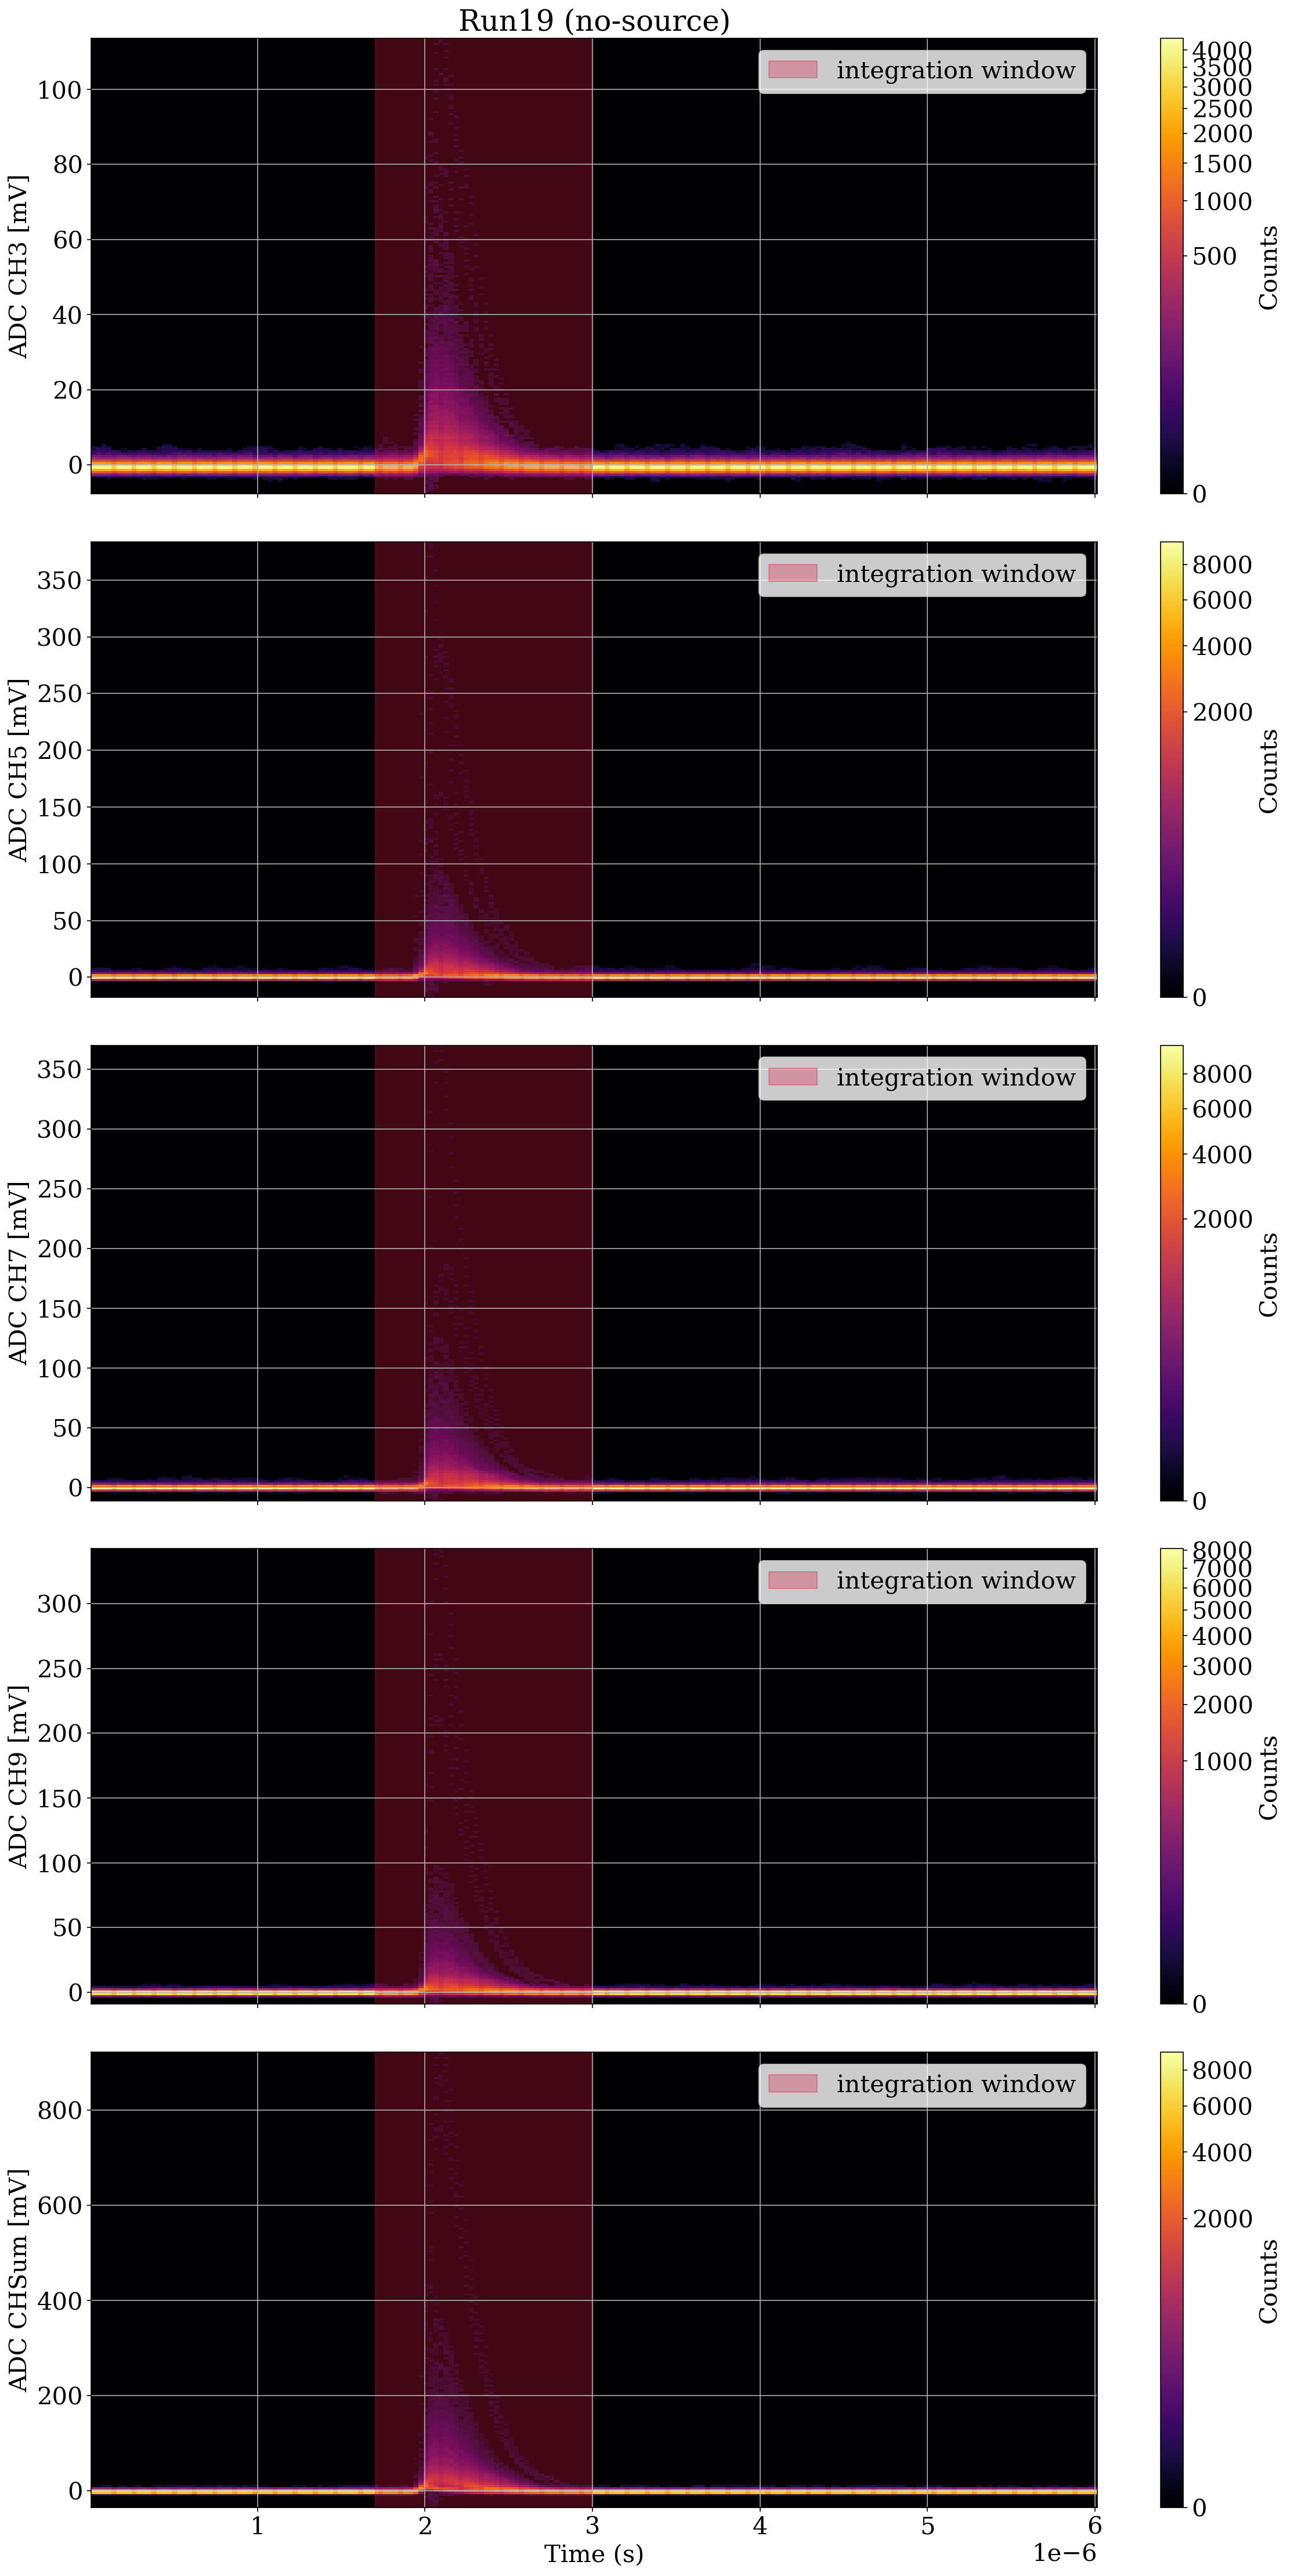

In [39]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_nosource['run']} ({data_nosource['source']})")
else:
    ax.set_title(f"{data_nosource['run']} ({data_nosource['source']})")


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = final_df_nosource[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_nosource, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_nosource.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_nosource[time_window_nosource], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

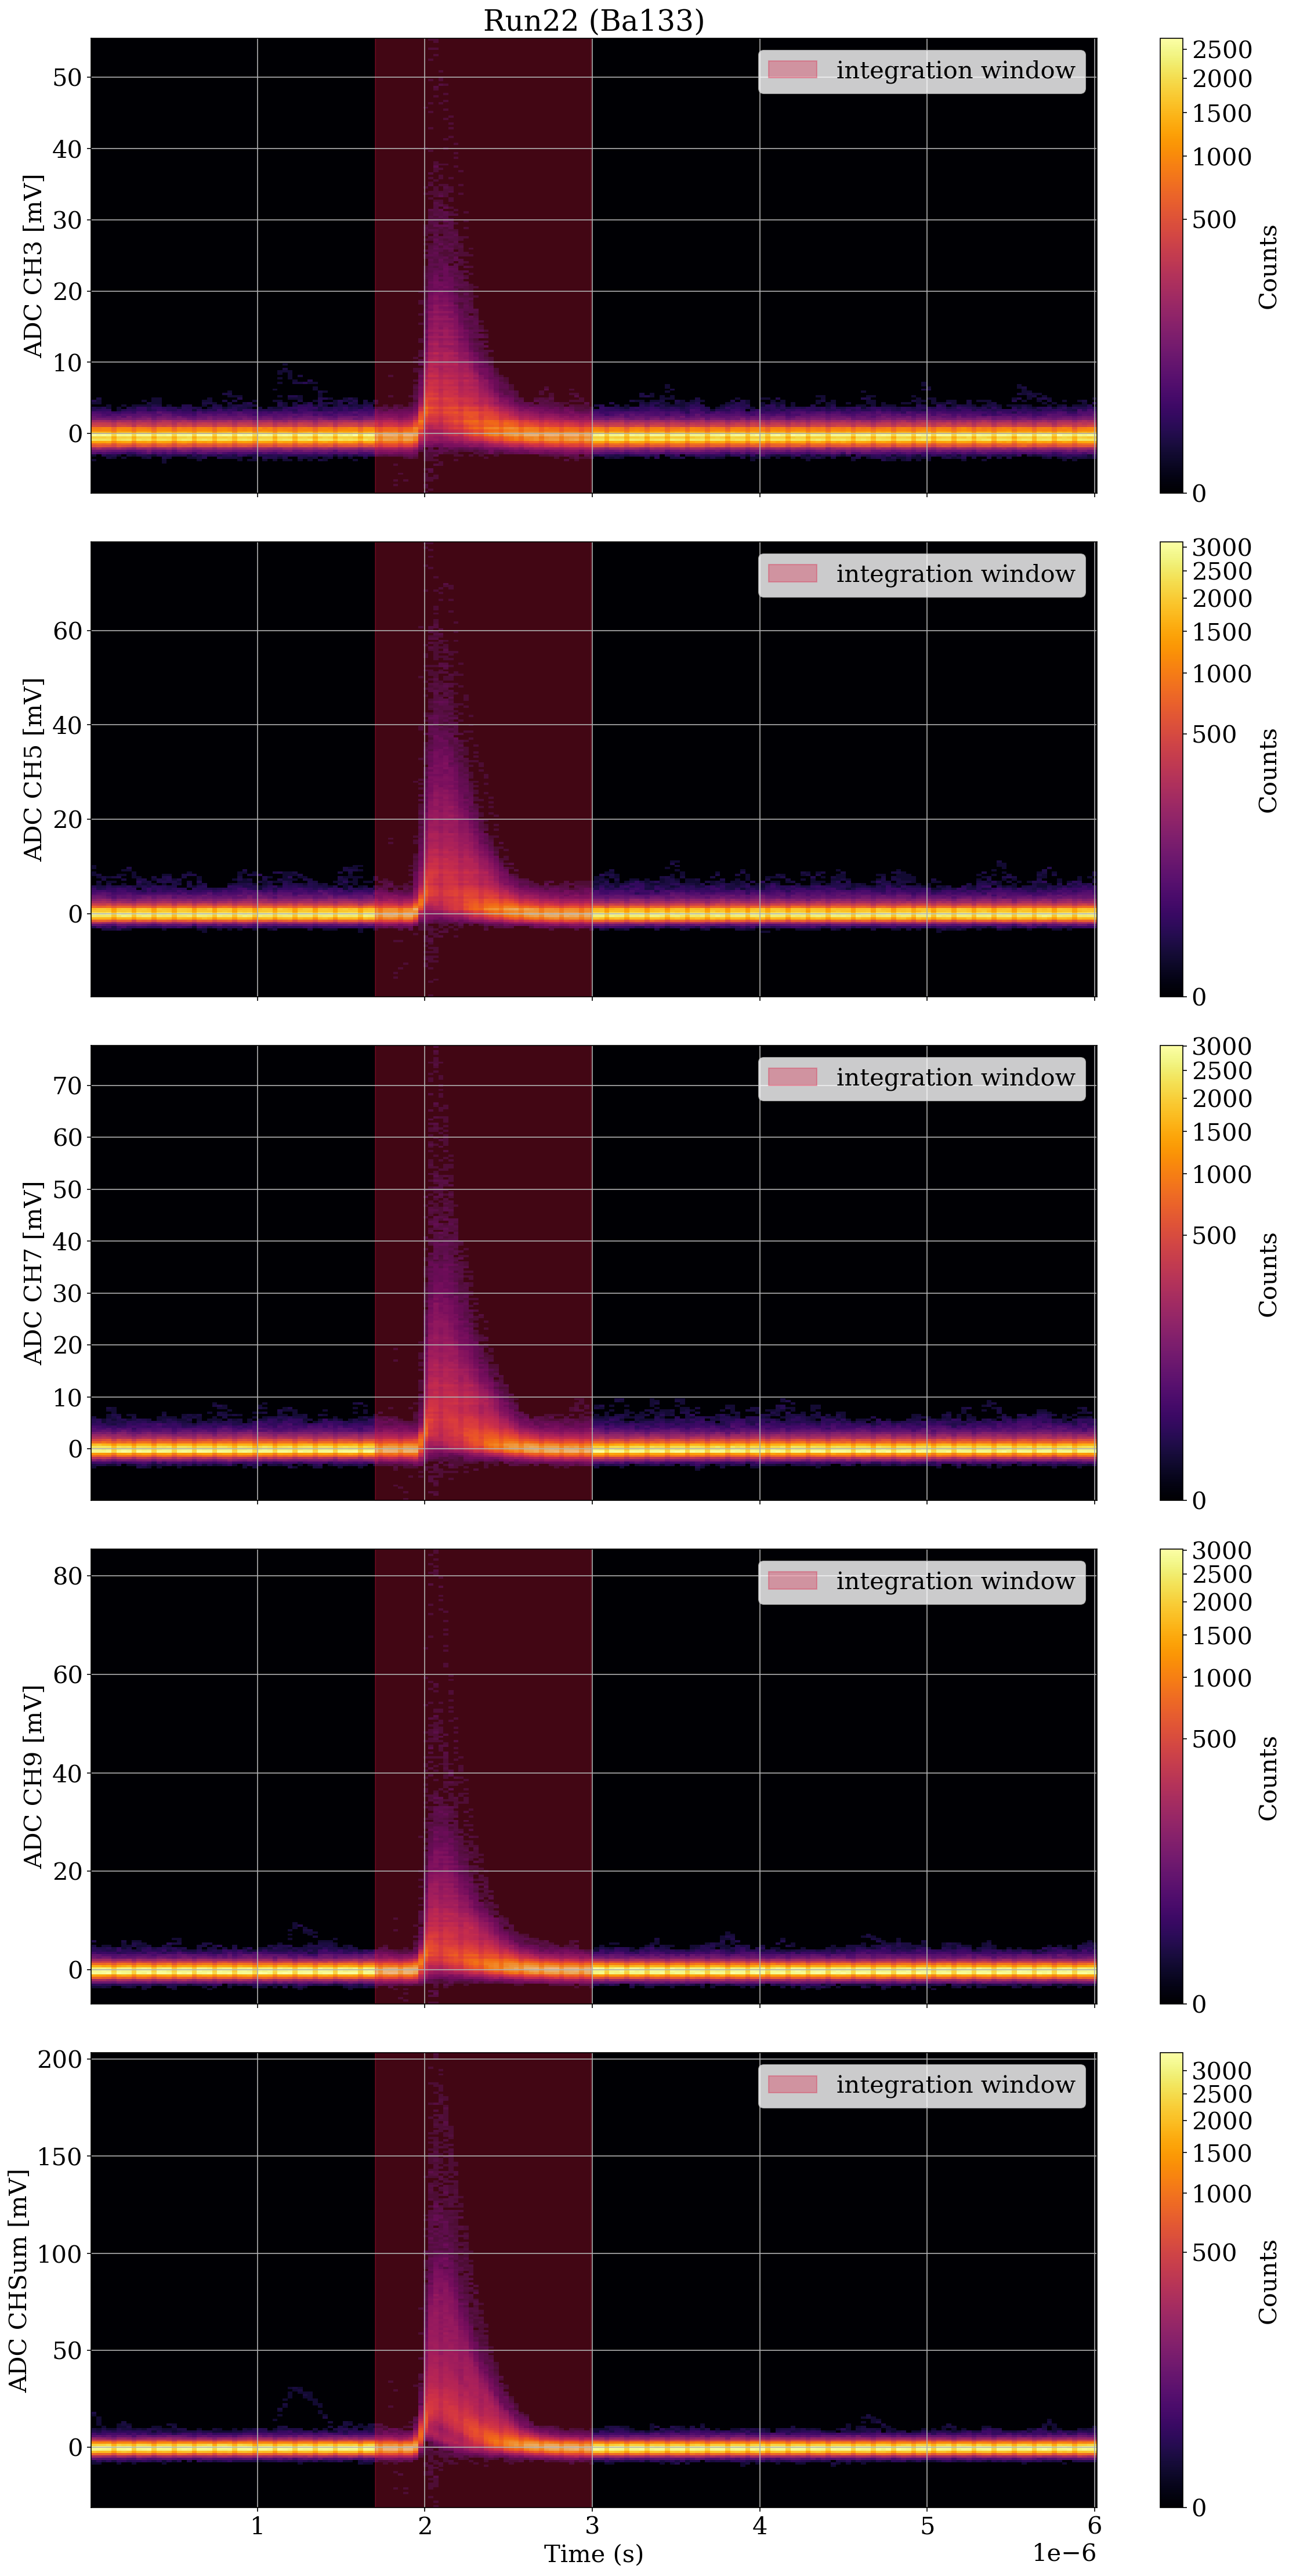

In [40]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_source['run']} ({data_source['source']})")
else:
    ax.set_title(f"{data_source['run']} ({data_source['source']})")


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = final_df_source[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_source, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_source.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_source[time_window_source], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

In [41]:
# # Create subplots: 2 rows, 1 column

# if len(channels) > 1:
#     fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
# else:
#     fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

# if len(channels) > 1:
#     axs[0].set_title(f"{data['run']} ({data['source']})")
# else:
#     ax.set_title(f"{data['run']} ({data['source']})")


# # Plot CHs
# for i in range(len(channels)):

#     if len(channels) > 1:
#         ax = axs[i]

#     voltage  = final_df[f'{channels[i]}'].values
#     v_matrix = voltage.reshape(nevents, -1)
#     # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
#     v_matrix_corrected = v_matrix
    
#     # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
#     hb = ax.hist2d(t_matrix.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
#                    cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

#     fig.colorbar(hb[3], ax=ax, label="Counts")

#     ax.fill_between(time[time_window], v_matrix_corrected.min(), v_matrix_corrected.max(), 
#                     color = colors[1], alpha = 0.3, label = 'integration window')

#     ax.set_ylabel(f'ADC {channels[i]} [mV]')
#     ax.grid(True)
#     ax.legend()

# if len(channels) > 1:
#     axs[-1].set_xlabel('Time (s)')
# else:
#     ax.set_xlabel('Time (s)')

# # plt.xlim(-2e-7,40e-7)

# # Improve layout
# plt.tight_layout()
# plt.show()

In [43]:
charge_Sum_nosource = 0

for i, ch in enumerate(channels):

    voltage = final_df_nosource[f'{channels[i]}'].values

    v_matrix                    = voltage.reshape(nevents_nosource, -1)
    # v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix

    charge = np.trapz(v_matrix_corrected[:, time_window_nosource]*1e-3,
                      x = time_nosource[time_window_nosource]
                      ,axis = 1)
    
    if data_nosource['pes']:
        if ch != 'CHSum':
            charge = cig.ChargeToPes(charge, channel=i+1, 
                                        temp = data_nosource['temperature'], amplified = data_nosource['is_amplified'], CHAmp=data_nosource['amp_factors'])
            charge_Sum_nosource = charge_Sum_nosource + charge

In [44]:
charge_Sum_source = 0

for i, ch in enumerate(channels):

    voltage = final_df_source[f'{channels[i]}'].values

    v_matrix                    = voltage.reshape(nevents_source, -1)
    # v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix

    charge = np.trapz(v_matrix_corrected[:, time_window_source]*1e-3,
                      x = time_source[time_window_source]
                      ,axis = 1)
    
    if data_source['pes']:
        if ch != 'CHSum':
            charge = cig.ChargeToPes(charge, channel=i+1, 
                                        temp = data_source['temperature'], amplified = data_source['is_amplified'], CHAmp=data_source['amp_factors'])
            charge_Sum_source = charge_Sum_source + charge

In [52]:
run_duration_nosource   = ((final_df_nosource.groupby('file_idx').max().event_time - final_df_nosource.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{data_nosource['run']} is {run_duration_nosource/60:.2f} mins long")
run_duration_source     = ((final_df_source.groupby('file_idx').max().event_time - final_df_source.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{data_source['run']} is {run_duration_source/60:.2f} mins long")

Run19 is 38.65 mins long
Run22 is 8.85 mins long


###  Calculate MC DCs

In [45]:
integration_window = time_window_max - time_window_min 

In [46]:
DCs = 0
for ii in range(len(channels[:-1])):

    ndarkcounts = DCR(f'CH{ii+1}', temperature)*integration_window
    DCs += np.random.poisson(lam = ndarkcounts, size = len(Nphotons_per_event))



In [47]:
DCR(f'CH{ii+1}', temperature)*1e-6

0.9750173629392817

##  LCE

In [48]:
Nphotons_per_event.min()

0.0019826908

In [112]:
def difference_histogram(data_phes_nosource, data_phes_source, 
                  run_duration_nosource, run_duration_source, nbins=None, threshold=None):
    
    # Apply threshold cut if defined
    if threshold is None:
        threshold = min(data_phes_nosource.min(), data_phes_source.min())

    
    data_nosource_cut   = data_phes_nosource[data_phes_nosource >= threshold]
    data_source_cut     = data_phes_source[data_phes_source >= threshold]

    # Same histogram range (based on data)
    hist_min = threshold
    hist_max = 0.5*max(data_nosource_cut.max(), data_source_cut.max())
    if nbins is None:
        nbins = int(np.sqrt(max(len(data_nosource_cut), len(data_source_cut))))
    
    # Compute histograms
    data_nosource_counts, bins  = np.histogram(data_nosource_cut, bins=nbins, range=(hist_min, hist_max))
    data_source_counts, _       = np.histogram(data_source_cut, bins=nbins, range=(hist_min, hist_max))

    # Normalize histograms
    data_nosource_counts    = data_nosource_counts / run_duration_nosource
    data_source_counts      = data_source_counts / run_duration_source

    difference_counts = data_source_counts - data_nosource_counts

    return difference_counts, bins, threshold, hist_min, hist_max


In [113]:
def cost_function(LCE, data_phes_nosource, data_phes_source, 
                  run_duration_nosource, run_duration_source,
                  Nphotons_per_event, DCs, nbins=None, threshold=None):
    """Return chi-square between data and MC for a given LCE."""
    
    # Generate MC
    mc_phes = detected_phes(Nphotons_per_event, LCE) + DCs
    
    difference_counts, bins, threshold, hist_min, hist_max = difference_histogram(data_phes_nosource = data_phes_nosource, 
                                                                                  data_phes_source = data_phes_source,
                                                                                  run_duration_nosource = run_duration_nosource, 
                                                                                  run_duration_source = run_duration_source, 
                                                                                  nbins=nbins,
                                                                                  threshold=threshold)

    mc_cut = mc_phes[mc_phes >= threshold]
    
    mc_counts, _                = np.histogram(mc_cut, bins=bins, range=(hist_min, hist_max))
    
    # Normalize histograms
    difference_counts = difference_counts / np.sum(difference_counts)
    mc_counts = mc_counts / np.sum(mc_counts)
    
    # Avoid zeros
    mask = (difference_counts > 0) & (mc_counts > 0)
    
    # Chi-square
    chi2 = np.sum((difference_counts[mask] - mc_counts[mask])**2 / mc_counts[mask])
    return chi2


In [114]:
# def cost_function(LCE, data_phes, Nphotons_per_event, DCs, nbins=None, threshold=None):
#     """Return chi-square between data and MC for a given LCE."""
    
#     # Generate MC
#     mc_phes = detected_phes(Nphotons_per_event, LCE) + DCs
    
   
#     # Apply threshold cut if defined
#     if threshold is None:
#         threshold = data_phes.min()
#     data_cut = data_phes[data_phes >= threshold]
#     mc_cut = mc_phes[mc_phes >= threshold]
    
#     # Same histogram range (based on data)
#     hist_min = threshold
#     hist_max = max(mc_cut.max(), data_cut.max())
#     # hist_max = data_cut.max()
#     if nbins is None:
#         nbins = int(np.sqrt(len(data_cut)))
    
#     # Compute histograms
#     data_counts, bins = np.histogram(data_cut, bins=nbins, range=(hist_min, hist_max))
#     mc_counts, _ = np.histogram(mc_cut, bins=bins, range=(hist_min, hist_max))
    
#     # Normalize histograms
#     data_counts = data_counts / np.sum(data_counts)
#     mc_counts = mc_counts / np.sum(mc_counts)
    
#     # Avoid zeros
#     mask = (data_counts > 0) & (mc_counts > 0)
    
#     # Chi-square
#     chi2 = np.sum((data_counts[mask] - mc_counts[mask])**2 / mc_counts[mask])
#     return chi2


In [115]:
# data_phes = charge_Sum

In [116]:
optimi = minimize_scalar(cost_function,
                         bounds=(1e-5, 0.1),  # adjust bounds as needed
                         method='bounded',
                         args=(charge_Sum_nosource, charge_Sum_source, 
                               run_duration_nosource, run_duration_source, 
                               Nphotons_per_event, DCs, None)
                         )

best_LCE = optimi.x
print(f"Best-fit LCE = {best_LCE*100:.2f}%")

Best-fit LCE = 1.99%


In [117]:
DCs

array([7, 5, 5, ..., 6, 1, 7])

##  Data vs MC

In [118]:
LCE = best_LCE # 1.32%
# LCE = 1.66/100 # 1.32%

In [119]:
mc_phes = detected_phes(Nphotons_per_event, LCE) + DCs

In [120]:
bins

array([6.18394026e+00, 2.47325414e+02, 4.88466887e+02, 7.29608360e+02,
       9.70749834e+02, 1.21189131e+03, 1.45303278e+03, 1.69417425e+03,
       1.93531573e+03, 2.17645720e+03, 2.41759867e+03, 2.65874015e+03,
       2.89988162e+03, 3.14102309e+03, 3.38216457e+03, 3.62330604e+03,
       3.86444751e+03, 4.10558899e+03, 4.34673046e+03, 4.58787193e+03,
       4.82901341e+03, 5.07015488e+03, 5.31129636e+03, 5.55243783e+03,
       5.79357930e+03, 6.03472078e+03, 6.27586225e+03, 6.51700372e+03,
       6.75814520e+03, 6.99928667e+03, 7.24042814e+03, 7.48156962e+03,
       7.72271109e+03, 7.96385256e+03, 8.20499404e+03, 8.44613551e+03,
       8.68727698e+03, 8.92841846e+03, 9.16955993e+03, 9.41070140e+03,
       9.65184288e+03, 9.89298435e+03, 1.01341258e+04, 1.03752673e+04,
       1.06164088e+04, 1.08575502e+04, 1.10986917e+04, 1.13398332e+04,
       1.15809747e+04, 1.18221161e+04, 1.20632576e+04, 1.23043991e+04,
       1.25455406e+04, 1.27866820e+04, 1.30278235e+04, 1.32689650e+04,
      

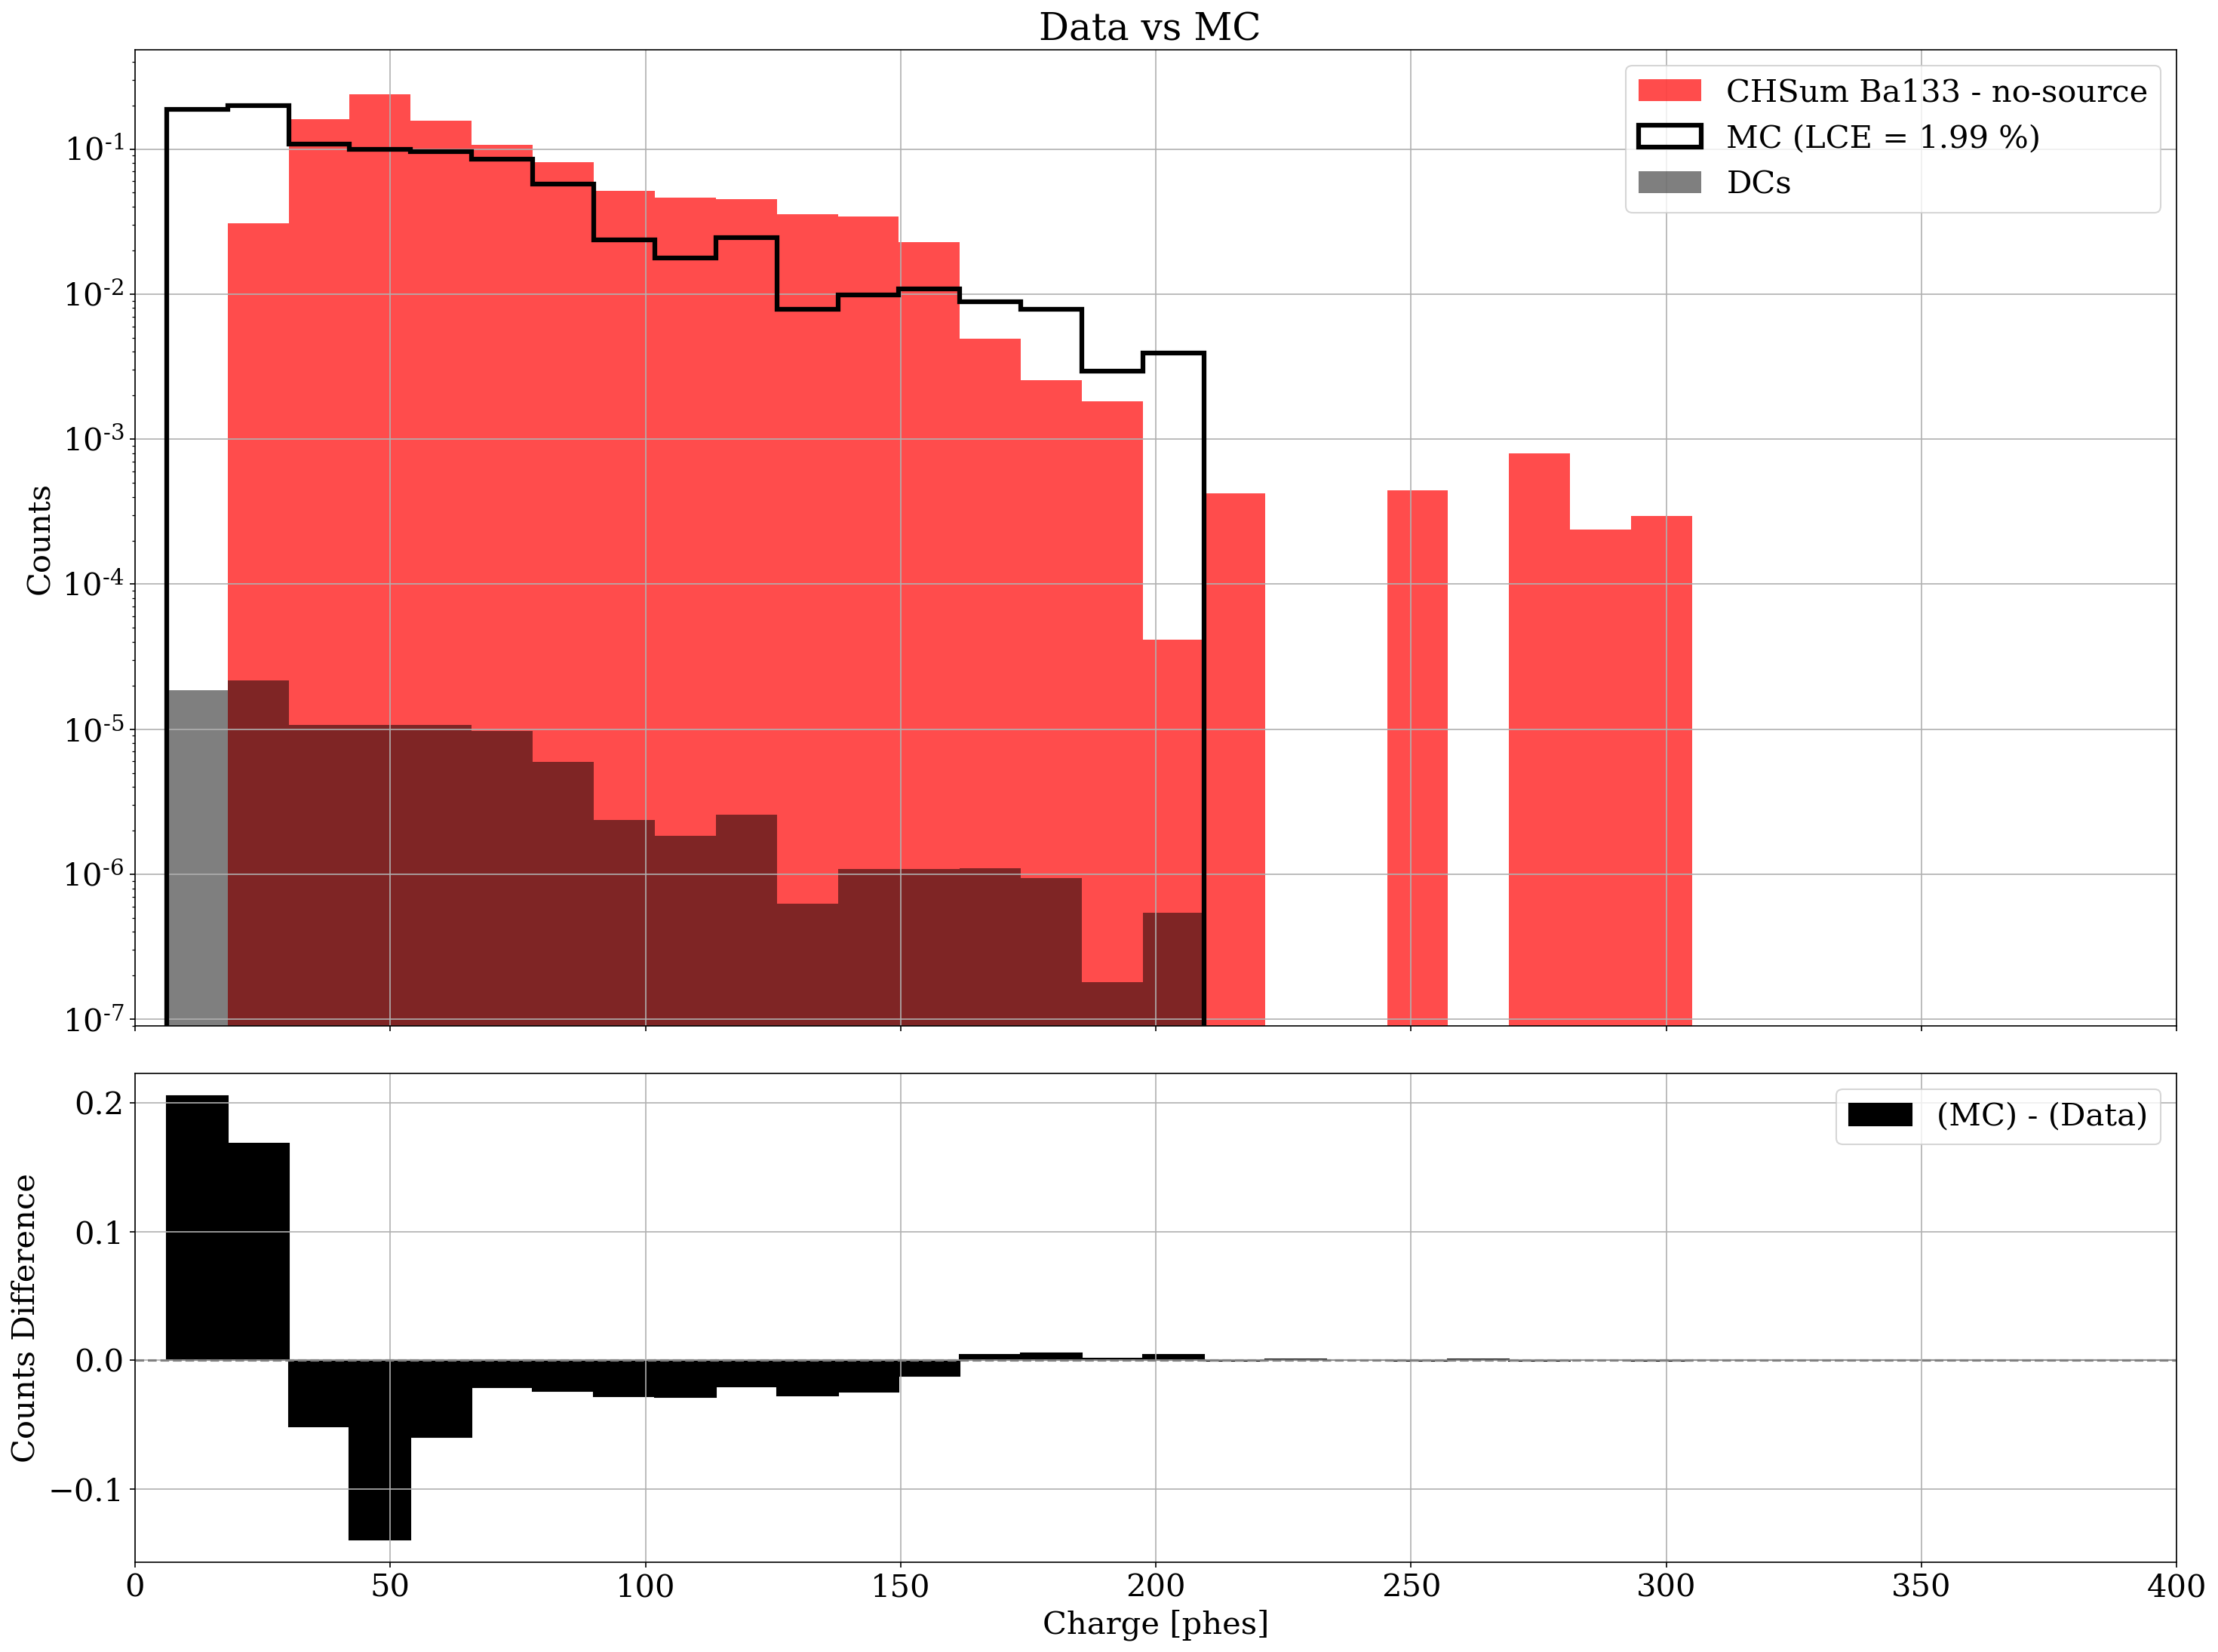

In [122]:
# Create subplots: 2 rows, 1 column

fig, axs = plt.subplots(2, 1,
                        figsize=(20, 15),
                        dpi=150,
                        sharex=True,
                        gridspec_kw={'height_ratios': [2, 1]}  # top subplot twice as tall
                        )

axs[0].set_title(f"Data vs MC ")

# PLOT 1: Histogram comparisson
ax = axs[0]


difference_counts, bins, threshold, hist_min, hist_max = difference_histogram(data_phes_nosource = charge_Sum_nosource, 
                                                                              data_phes_source = charge_Sum_source,
                                                                              run_duration_nosource = run_duration_nosource, 
                                                                              run_duration_source = run_duration_source, 
                                                                              nbins=None,
                                                                              threshold=None)

# hist_max = data_phes.max()
hist_max = 300
bins_mean = 0.5*(bins[:-1] + bins[1:])

events_data, bins_data, image = ax.hist(bins_mean
                                        ,bins = bins 
                                        # ,bins = bins_mc 
                                        # ,bins = nbins 
                                        ,weights=difference_counts/difference_counts.sum()
                                        ,range = (hist_min, hist_max)
                                        ,density = False
                                        ,histtype   ='stepfilled'
                                        ,color      = 'r'
                                        ,ls         = '-'
                                        ,lw         = 3
                                        ,alpha      = 0.7
                                        ,label = f"{ch} {data_source['source']} - {data_nosource['source']}"
                                        )

events_mc, bins_mc, image = ax.hist(mc_phes
                                    # ,bins =  int(np.sqrt(len(mc_phes))) 
                                    ,bins =  bins_data
                                    # ,bins =  nbins
                                    ,weights=np.ones_like(mc_phes)/len(mc_phes)
                                    # ,range = (hist_min, hist_max)
                                    ,density = False
                                    ,histtype   ='step'
                                    ,color      = 'k'
                                    ,ls         = '-'
                                    ,lw         = 3
                                    ,alpha      = 1
                                    ,label = f"MC (LCE = {LCE*100:.2f} %)"
                                    )

_, _, _ = ax.hist(mc_phes
                                    # ,bins =  int(np.sqrt(len(mc_phes))) 
                                    ,bins =  bins_data
                                    # ,bins =  nbins
                                    ,weights=(DCs)/sum(mc_phes)/len(mc_phes)
                                    ,range = (hist_min, hist_max)
                                    ,density = False
                                    ,histtype   ='stepfilled'
                                    ,color      = 'k'
                                    ,ls         = '-'
                                    ,lw         = 3
                                    ,alpha      = 0.5
                                    ,label = f"DCs"
                                    )
    
    
ax.set_ylabel(fr'Counts')
ax.grid(True)
ax.set_yscale('log')
ax.legend()

# PLOT 2: Histograms difference
ax = axs[1]

bin_centers = (bins_data[1:] + bins_data[:-1])/2

events_difference = events_mc - events_data

width = np.diff(bins_data)
ax.bar(bin_centers, events_difference, width=width, align='center',
       color='k', edgecolor='k', alpha=1, label=f"(MC) - (Data)")

ax.axhline(0, color='grey', linestyle='--')
ax.set_ylabel(fr'Counts Difference')
ax.set_yscale('linear')     # linear to show negatives
ax.grid(True)
ax.legend()


ax.set_xlim(0, 400)

if pes:
    axs[-1].set_xlabel(r'Charge [phes]')
else:
    axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')

# Improve layout
plt.tight_layout()
plt.show()

In [84]:
# # Create subplots: 2 rows, 1 column

# fig, axs = plt.subplots(2, 1,
#                         figsize=(20, 15),
#                         dpi=150,
#                         sharex=True,
#                         gridspec_kw={'height_ratios': [2, 1]}  # top subplot twice as tall
#                         )

# axs[0].set_title(f"Data vs MC ")

# # PLOT 1: Histogram comparisson
# ax = axs[0]

# nbins = max(int(np.sqrt(len(mc_phes))), int(np.sqrt(len(data_phes))))

# hist_min = min(mc_phes.min(), data_phes.min())
# hist_max = max(mc_phes.max(), data_phes.max())
# # hist_max = data_phes.max()
# hist_max = 300


# events_data, bins_data, image = ax.hist(data_phes
#                                         ,bins = int(np.sqrt(len(data_phes))*0.99) 
#                                         # ,bins = bins_mc 
#                                         # ,bins = nbins 
#                                         ,weights=np.ones_like(data_phes)/len(data_phes)
#                                         ,range = (hist_min, hist_max)
#                                         ,density = False
#                                         ,histtype   ='stepfilled'
#                                         ,color      = 'r'
#                                         ,ls         = '-'
#                                         ,lw         = 3
#                                         ,alpha      = 0.7
#                                         ,label = f"{ch} {data['source']}"
#                                         )

# events_mc, bins_mc, image = ax.hist(mc_phes
#                                     # ,bins =  int(np.sqrt(len(mc_phes))) 
#                                     ,bins =  bins_data
#                                     # ,bins =  nbins
#                                     ,weights=np.ones_like(mc_phes)/len(mc_phes)
#                                     # ,range = (hist_min, hist_max)
#                                     ,density = False
#                                     ,histtype   ='step'
#                                     ,color      = 'k'
#                                     ,ls         = '-'
#                                     ,lw         = 3
#                                     ,alpha      = 1
#                                     ,label = f"MC (LCE = {LCE*100:.2f} %)"
#                                     )

# _, _, _ = ax.hist(mc_phes
#                                     # ,bins =  int(np.sqrt(len(mc_phes))) 
#                                     ,bins =  bins_data
#                                     # ,bins =  nbins
#                                     ,weights=(DCs)/sum(mc_phes)/len(mc_phes)
#                                     ,range = (hist_min, hist_max)
#                                     ,density = False
#                                     ,histtype   ='stepfilled'
#                                     ,color      = 'k'
#                                     ,ls         = '-'
#                                     ,lw         = 3
#                                     ,alpha      = 0.5
#                                     ,label = f"DCs"
#                                     )
    
    
# ax.set_ylabel(fr'Counts')
# ax.grid(True)
# ax.set_yscale('log')
# ax.legend()

# # PLOT 2: Histograms difference
# ax = axs[1]

# bin_centers = (bins_data[1:] + bins_data[:-1])/2

# events_difference = events_mc - events_data

# width = np.diff(bins_data)
# ax.bar(bin_centers, events_difference, width=width, align='center',
#        color='k', edgecolor='k', alpha=1, label=f"(MC) - (Data)")

# ax.axhline(0, color='grey', linestyle='--')
# ax.set_ylabel(fr'Counts Difference')
# ax.set_yscale('linear')     # linear to show negatives
# ax.grid(True)
# ax.legend()




# if pes:
#     axs[-1].set_xlabel(r'Charge [phes]')
# else:
#     axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')

# # Improve layout
# plt.tight_layout()
# plt.show()

In [43]:
len(DCs)

1016

In [44]:
mc_phes.min(), data_phes.min()

(1, 6.901252035620381)

In [45]:
events_data.sum(), events_mc.sum()

(0.9982094897045667, 0.9999999999999983)